# ResNet Model for CIFAR-10 Image Classification
## Deep Learning Mini Project

### Team: SPK
Sarthak Gupta (sg8304) &emsp; Pratik Pattanaik (pp2861) &emsp; Krish Panchal (khp3878)

## Training the model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms.v2 as v2

from torch.utils.data import Dataset, DataLoader

import time

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


### Prepare Data
Download train and test CIFAR-10 data and create dataloaders for them.
Also use data augmentaion and normalization specific for this dataset.

In [3]:
#downloading the dataset and dividing into test and train
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train = v2.Compose([
    v2.RandomCrop(32, padding = 4),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.Normalize(*stats,inplace=True)
])

test = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(*stats)
])

train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download = True, transform = train)
test_dataset = torchvision.datasets.CIFAR10(root= './data', train = False, download = True, transform = test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False, num_workers = 4)

C:\Users\sartg\anaconda3\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


### Define Model
Code for our model with best results has been adapted from the following github [repo](https://github.com/Nikunj-Gupta/Efficient_ResNets). We have used same hyperparameters as mentioned in their config for best model.

In [4]:
# Efficient ResNet Model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, conv_kernel_size=3, shortcut_kernel_size=1, drop=0.4):
        """
        Convolutional Layer kernel size Fi 
        Skip connection (shortcut) kernel size Ki 
        """
        super(BasicBlock, self).__init__()
        self.drop = drop 
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=conv_kernel_size, stride=stride, padding=int(conv_kernel_size/2), bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=conv_kernel_size,stride=1, padding=int(conv_kernel_size/2), bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=shortcut_kernel_size, stride=stride, padding=int(shortcut_kernel_size/2), bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        if self.drop: self.dropout = nn.Dropout(self.drop)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        if self.drop: out = self.dropout(out)
        return out



def conv1x1(in_channels,
            out_channels,
            stride=1,
            groups=1,
            bias=False):
    """
    Convolution 1x1 layer.
    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    """
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        groups=groups,
        bias=bias)

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    Parameters:
    ----------
    channels : int
        Number of channels.
    reduction : int, default 16
        Squeeze reduction value.
    """
    def __init__(self,
                 channels,
                 reduction=16):
        super(SEBlock, self).__init__()
        mid_cannels = channels // reduction

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(
            in_channels=channels,
            out_channels=mid_cannels,
            bias=True)
        self.activ = nn.ReLU(inplace=True) 

        self.conv2 = conv1x1(
            in_channels=mid_cannels,
            out_channels=channels,
            bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        x = x * w
        return x


class ResNet(nn.Module):
    def __init__(
            self, 
            block, 
            num_blocks, 
            conv_kernel_sizes=None, 
            shortcut_kernel_sizes=None,
            num_classes=10, 
            num_channels=32, 
            avg_pool_kernel_size=4, 
            drop=None, 
            squeeze_and_excitation=None):
        super(ResNet, self).__init__()
        self.in_planes = num_channels
        # self.avg_pool_kernel_size = avg_pool_kernel_size 
        self.avg_pool_kernel_size = int(32 / (2**(len(num_blocks)-1)))
        
        """
        # of channels Ci 
        """
        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.num_channels) 

        self.drop = drop 
        self.squeeze_and_excitation = squeeze_and_excitation 

        if self.squeeze_and_excitation: 
            self.seblock = SEBlock(channels=self.num_channels) 

        """
        # of Residual Layers N 
        # of Residual Blocks Bi 
        """
        self.residual_layers = [] 
        for n in range(len(num_blocks)): 
            stride = 1 if n==0 else 2 # stride=1 for first residual layer, and stride=2 for the remaining layers 
            conv_kernel_size = conv_kernel_sizes[n] if conv_kernel_sizes else 3 # setting default kernel size of block's convolutional layers 
            shortcut_kernel_size = shortcut_kernel_sizes[n] if shortcut_kernel_sizes else 1 # setting default kernel size of block's skip connection (shortcut) layers 
            self.residual_layers.append(self._make_layer(
                                                    block, 
                                                    self.num_channels*(2**n), 
                                                    num_blocks[n], 
                                                    stride=stride, 
                                                    conv_kernel_size=conv_kernel_size, 
                                                    shortcut_kernel_size=shortcut_kernel_size)) 

        self.residual_layers = nn.ModuleList(self.residual_layers)
        self.linear = nn.Linear(self.num_channels*(2**n)*block.expansion, num_classes) 
        """
        Dropout layer 
        """
        if self.drop: 
            self.dropout = nn.Dropout(self.drop) # Define proportion or neurons to dropout

    def _make_layer(self, block, planes, num_blocks, stride, conv_kernel_size, shortcut_kernel_size):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, conv_kernel_size, shortcut_kernel_size, drop=self.drop))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.squeeze_and_excitation: out = self.seblock(out) 
        for layer in self.residual_layers: 
            out = layer(out)         
        """
        Average pool kernel size 
        """
        out = F.avg_pool2d(out, self.avg_pool_kernel_size)
        out = out.view(out.size(0), -1)
        if self.drop: out = self.dropout(out)
        out = self.linear(out)
        return out


def efficient_resnet_model(config=None): 
    # Best Model 
    net =  ResNet(
            block=BasicBlock, 
            num_blocks=[4, 4, 3],                          # N: number of Residual Layers | Bi:Residual blocks in Residual Layer i 
            conv_kernel_sizes=[3, 3, 3],            # Fi: Conv. kernel size in Residual Layer i 
            shortcut_kernel_sizes=[1, 1, 1] ,    # Ki: Skip connection kernel size in Residual Layer i 
            num_channels=64,                      # Ci: # channels in Residual Layer i 
            avg_pool_kernel_size=8,      # P: Average pool kernel size 
            drop=0,                                      # use dropout with drop proportion 
            squeeze_and_excitation=1   # Enable/disable Squeeze-and-Excitation Block 
        ) 
    
    return net

### Define Optimizer
We have used the Lookahead Optimizer implementation from the same [repo](https://github.com/Nikunj-Gupta/Efficient_ResNets) as for the model

In [5]:
from collections import defaultdict
from itertools import chain
from torch.optim import Optimizer
import torch
import warnings

class Lookahead(Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0
    
    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)
    
    def update_lookahead(self):
        for group in self.param_groups:
            self.update(group)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss

    def zero_grad(self):
        self.optimizer.zero_grad()
        
    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }

    def load_state_dict(self, state_dict):
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)

Initialize the model and print summary

In [6]:
model = efficient_resnet_model()
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (seblock): SEBlock(
    (pool): AdaptiveAvgPool2d(output_size=1)
    (conv1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
    (activ): ReLU(inplace=True)
    (conv2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  (residual_layers): ModuleList(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_siz

#### Check number of parameters
Print the number of trainable parameters in this model.

In [7]:
# To find the trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 4697742


Initialize the Loss, Lookahead optimizer and Scheduler for 200 epochs

In [8]:
#defining the loss and optimizer function
n_epochs = 200
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1,
                          nesterov=True, momentum=0.9, weight_decay=0.0005)
optimizer = Lookahead(optimizer, k=5, alpha=0.5) # Initialize Lookahead 

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

optimizer

Lookahead (
Parameter Group 0
    counter: 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)

In [9]:
PATH = './models'
history = {
    'train_losses':[],
    'valid_losses':[],
    'valid_accuracies':[],
    'lr_list':[],
    'epochs':[],
    'best_accuracy':0
}

### Define training procedure
Here we are saving the model with best accuracy on validation data (**best_model**) and also the model after all the epochs are run (**latest_model**).

We are using gradient clipping to stabilize training.
We also use cutmix_or_mixup during finetuning to improve generalization capability of our model.

In [10]:
def training(model, optimizer, train_loader, test_loader, n_epochs, history, use_cutmix_or_mixup=False, previous_epoch=0, PATH = './models'):
    PATH = './models'
    epochs= n_epochs
    grad_clip = 0.1
    if use_cutmix_or_mixup:
        print("Using CutMix and MixUp for regularization")
    for e in range(epochs):
        train_loss=0.0
        valid_loss=0.0
        train_time = 0
        train_acc=[]
        test_acc = 0.0
        time_start = time.perf_counter()
        
        model.train()
        for images,labels in train_loader:
            if use_cutmix_or_mixup:
                images, labels = cutmix_or_mixup(images, labels)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_ps=model(images)
            loss=criterion(log_ps,labels)
            train_loss+=loss.item()*images.size(0)

            loss.backward()
            if grad_clip: 
                    nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
        time_train = time.perf_counter()
        
        model.eval()
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item() * images.size(0)

            prediction = torch.argmax(output, dim=1)
            k=torch.sum(prediction == labels)
            test_acc += k.item()
        time_eval = time.perf_counter()
        training_time = time_train- time_start
        evaluation_time = time_eval-time_train

        history['lr_list'].append(scheduler.get_last_lr())

        scheduler.step()

        train_loss=train_loss/len(train_loader.sampler)
        history['train_losses'].append(train_loss)

        valid_loss=valid_loss/len(test_loader.sampler)
        history['valid_losses'].append(valid_loss)
        
        accuracy = 100*test_acc/len(test_loader.sampler)
        history['valid_accuracies'].append(accuracy)
        
        history['epochs'].append(e+1+previous_epoch)

        if history['best_accuracy'] < accuracy:
            torch.save(model.state_dict(), PATH+'/best_model')
            history['best_accuracy']=accuracy

        print('epoch:{}  train loss :{:.6f}\t valid loss :{:.6f}\t validation accuracy :{:.2f}\t train time :{:.2f}\t eval time :{:.2f}'.format(
              e+1,
              train_loss,
              valid_loss,
              accuracy,
              training_time,
              evaluation_time

          ))

    torch.save(model.state_dict(), PATH+'/latest_model')
    return model, history

### Start Training
Train the model for 200 epochs first as mentioned in the Efficient ResNets repo

In [11]:
n_epochs=200
model, history = training(model, optimizer, train_loader, test_loader, n_epochs, history)

epoch:1  train loss :1.683114	 valid loss :1.280305	 validation accuracy :52.31	 train time :40.07	 eval time :14.60
epoch:2  train loss :1.165273	 valid loss :1.055408	 validation accuracy :62.93	 train time :39.09	 eval time :14.28
epoch:3  train loss :0.910796	 valid loss :0.888195	 validation accuracy :69.42	 train time :39.27	 eval time :13.90
epoch:4  train loss :0.756789	 valid loss :0.886245	 validation accuracy :69.17	 train time :39.46	 eval time :13.88
epoch:5  train loss :0.638676	 valid loss :0.823401	 validation accuracy :71.80	 train time :39.01	 eval time :13.58
epoch:6  train loss :0.549689	 valid loss :0.526627	 validation accuracy :81.98	 train time :38.95	 eval time :13.63
epoch:7  train loss :0.491020	 valid loss :0.632021	 validation accuracy :78.96	 train time :39.07	 eval time :15.79
epoch:8  train loss :0.450182	 valid loss :0.594449	 validation accuracy :80.17	 train time :60.82	 eval time :15.39
epoch:9  train loss :0.414390	 valid loss :0.624279	 validation 

epoch:71  train loss :0.121410	 valid loss :0.269748	 validation accuracy :91.66	 train time :39.34	 eval time :14.65
epoch:72  train loss :0.125685	 valid loss :0.282205	 validation accuracy :91.10	 train time :39.45	 eval time :13.92
epoch:73  train loss :0.124049	 valid loss :0.348869	 validation accuracy :89.09	 train time :39.59	 eval time :14.16
epoch:74  train loss :0.119675	 valid loss :0.375815	 validation accuracy :88.91	 train time :39.42	 eval time :14.19
epoch:75  train loss :0.121997	 valid loss :0.409341	 validation accuracy :87.91	 train time :39.36	 eval time :14.05
epoch:76  train loss :0.121902	 valid loss :0.289518	 validation accuracy :90.83	 train time :39.48	 eval time :13.65
epoch:77  train loss :0.118482	 valid loss :0.334985	 validation accuracy :89.89	 train time :39.55	 eval time :14.06
epoch:78  train loss :0.115712	 valid loss :0.366887	 validation accuracy :89.43	 train time :39.54	 eval time :14.02
epoch:79  train loss :0.115442	 valid loss :0.413103	 va

epoch:141  train loss :0.018537	 valid loss :0.227351	 validation accuracy :93.85	 train time :39.98	 eval time :13.98
epoch:142  train loss :0.013497	 valid loss :0.230275	 validation accuracy :93.98	 train time :39.56	 eval time :14.28
epoch:143  train loss :0.012612	 valid loss :0.236493	 validation accuracy :93.72	 train time :40.00	 eval time :13.98
epoch:144  train loss :0.013315	 valid loss :0.248957	 validation accuracy :93.86	 train time :40.06	 eval time :14.66
epoch:145  train loss :0.010377	 valid loss :0.211184	 validation accuracy :94.56	 train time :39.70	 eval time :14.06
epoch:146  train loss :0.008273	 valid loss :0.203504	 validation accuracy :94.80	 train time :39.52	 eval time :13.86
epoch:147  train loss :0.009189	 valid loss :0.222834	 validation accuracy :94.25	 train time :39.70	 eval time :15.57
epoch:148  train loss :0.006843	 valid loss :0.213459	 validation accuracy :94.46	 train time :40.36	 eval time :13.95
epoch:149  train loss :0.005506	 valid loss :0.1

In [12]:
# Print best accuracy on validation data
print(history['best_accuracy'])

95.86


Check final training and validation data accuracy of trained model

In [13]:
# train accuracy
train_acc = 0.0
for images,labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        prediction = torch.argmax(outputs, dim=1)
        k=torch.sum(prediction == labels)
        train_acc += k.item()

train_acc = 100*train_acc/len(train_dataset)
print(f'train accuracy: {train_acc}',)

train accuracy: 100.0


In [14]:
# test accuracy
test_acc = 0.0
for images,labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        prediction = torch.argmax(outputs, dim=1)
        k=torch.sum(prediction == labels)
        test_acc += k.item()

test_acc = 100*test_acc/len(test_dataset)
print(f'test accuracy: {test_acc}',)

test accuracy: 95.73


Plot training and validation loss while training

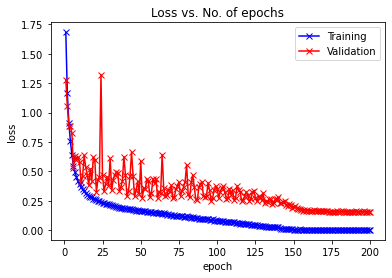

In [15]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.plot(epochs, train_losses, '-bx')
    plt.plot(epochs, valid_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history['train_losses'], history['valid_losses'], history['epochs'])

Plot validation accuracies while training

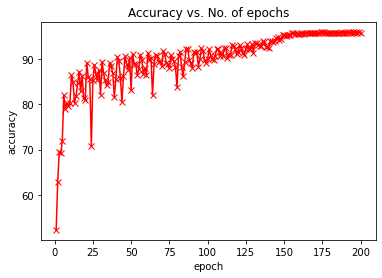

In [16]:
def plot_accuracies(valid_accuracies, epochs):
    plt.plot(epochs,valid_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history['valid_accuracies'], history['epochs'])

Plot how the learning rate is changing with epochs.

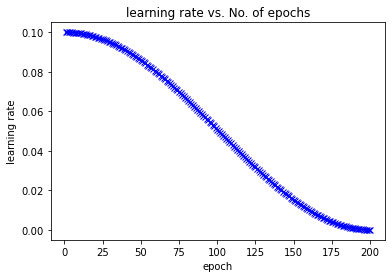

In [17]:
def plot_learning_rates(lr_list, epochs):
    plt.plot(epochs, lr_list, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('learning rate')
    plt.title('learning rate vs. No. of epochs');
plot_learning_rates(history['lr_list'], history['epochs'])

#### Checkpoint 1

With this configuration we were able to reach **0.859** score on kaggle on no labeled data.
To further regularize the model we decided to finetune it with [CutMix and MixUp](https://pytorch.org/vision/master/auto_examples/transforms/plot_cutmix_mixup.html) for further 100 epochs with smaller learning rate of 0.001

In [18]:
# MixUp and CutMix
NUM_CLASSES=10
cutmix = v2.CutMix(alpha=0.5, num_classes=NUM_CLASSES)
mixup = v2.MixUp(alpha=0.4, num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

In [19]:
#defining the optimizer function for finetuning
n_epochs = 100
optimizer = optim.SGD(model.parameters(), lr=0.001,
                          nesterov=True, momentum=0.9, weight_decay=0.0005)
optimizer = Lookahead(optimizer, k=5, alpha=0.5) # Initialize Lookahead 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

In [20]:
# Continue training for 100 epochs with use_cutmix_or_mixup set to True this time
previous_epoch=200
model, history = training(model, optimizer, train_loader, test_loader, n_epochs, history, True, previous_epoch)

Using CutMix and MixUp for regularization
epoch:1  train loss :0.973194	 valid loss :0.275148	 validation accuracy :95.14	 train time :39.58	 eval time :14.29
epoch:2  train loss :0.837806	 valid loss :0.227151	 validation accuracy :95.08	 train time :40.21	 eval time :14.16
epoch:3  train loss :0.903812	 valid loss :0.225332	 validation accuracy :95.13	 train time :40.39	 eval time :13.98
epoch:4  train loss :0.863263	 valid loss :0.248032	 validation accuracy :95.24	 train time :40.38	 eval time :13.98
epoch:5  train loss :0.770846	 valid loss :0.231073	 validation accuracy :95.32	 train time :40.41	 eval time :14.42
epoch:6  train loss :0.844925	 valid loss :0.247239	 validation accuracy :95.24	 train time :40.95	 eval time :14.11
epoch:7  train loss :0.810787	 valid loss :0.222058	 validation accuracy :95.47	 train time :40.81	 eval time :14.15
epoch:8  train loss :0.862276	 valid loss :0.227907	 validation accuracy :95.29	 train time :40.89	 eval time :14.39
epoch:9  train loss :0

epoch:71  train loss :0.779442	 valid loss :0.241271	 validation accuracy :95.89	 train time :40.27	 eval time :13.86
epoch:72  train loss :0.720972	 valid loss :0.202312	 validation accuracy :95.99	 train time :40.31	 eval time :13.89
epoch:73  train loss :0.692830	 valid loss :0.220801	 validation accuracy :95.93	 train time :40.35	 eval time :13.82
epoch:74  train loss :0.740810	 valid loss :0.177278	 validation accuracy :96.03	 train time :40.18	 eval time :13.83
epoch:75  train loss :0.713502	 valid loss :0.192098	 validation accuracy :96.05	 train time :40.30	 eval time :13.88
epoch:76  train loss :0.735494	 valid loss :0.177066	 validation accuracy :96.05	 train time :40.36	 eval time :13.81
epoch:77  train loss :0.704902	 valid loss :0.186331	 validation accuracy :96.10	 train time :40.18	 eval time :13.82
epoch:78  train loss :0.759098	 valid loss :0.192170	 validation accuracy :96.03	 train time :40.24	 eval time :13.70
epoch:79  train loss :0.720089	 valid loss :0.197869	 va

Plot training and validation loss for these 100 epochs

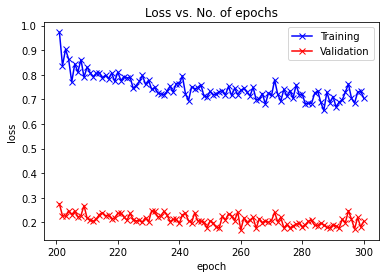

In [21]:
# plot_losses(history['train_losses'][10:], history['valid_losses'][10:], history['epochs'][10:])

plot_losses(history['train_losses'][200:], history['valid_losses'][200:], history['epochs'][200:])

Plot how the accuracy is changing for these 100 epochs

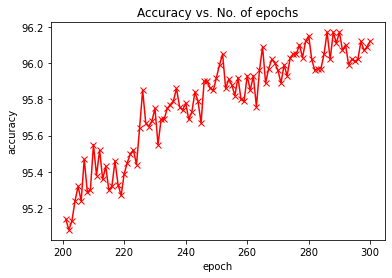

In [22]:
# plot_accuracies(history['valid_accuracies'][10:], history['epochs'][10:])

plot_accuracies(history['valid_accuracies'][200:], history['epochs'][200:])

Let's plot average accuracy over intervals of 10 epochs as that would give a clearer picture

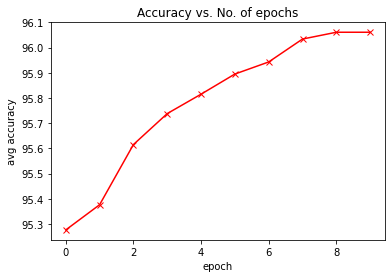

In [23]:
import math
def plot_avg_accuracies(avg_accuracies):
    plt.plot(avg_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('avg accuracy')
    plt.title('Accuracy vs. No. of epochs');

finetune_valid_accuracies = history['valid_accuracies'][200:]
# finetune_valid_accuracies = history['valid_accuracies'][10:20]
avg_accuracies = [math.fsum(finetune_valid_accuracies[i*10:i*10+10])/10 for i in range(len(finetune_valid_accuracies)//10)]

plot_avg_accuracies(avg_accuracies)


#### Checkpoint 2
With this model on kaggle we were able to get **0.870** score on unlabelled data, an improvement over previous score of 0.859.
From the above graph it looks like we the validation accuracy still hasn't plateaued, so we decided to train it for further 30 epochs with a learning rate of 0.0001.

In [24]:
#defining the optimizer function for finetuning
n_epochs = 30
optimizer = optim.SGD(model.parameters(), lr=0.0001,
                          nesterov=True, momentum=0.9, weight_decay=0.0005)
optimizer = Lookahead(optimizer, k=5, alpha=0.5) # Initialize Lookahead 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

In [25]:
# Continue training for 30 epochs keeping use_cutmix_or_mixup set to True
previous_epoch = 300
model, history = training(model, optimizer, train_loader, test_loader, n_epochs, history, True, previous_epoch)

Using CutMix and MixUp for regularization
epoch:1  train loss :0.697211	 valid loss :0.197258	 validation accuracy :96.13	 train time :40.15	 eval time :13.91
epoch:2  train loss :0.682027	 valid loss :0.178255	 validation accuracy :96.04	 train time :40.35	 eval time :13.86
epoch:3  train loss :0.708619	 valid loss :0.220213	 validation accuracy :95.98	 train time :40.27	 eval time :13.90
epoch:4  train loss :0.697684	 valid loss :0.196797	 validation accuracy :96.03	 train time :40.35	 eval time :13.83
epoch:5  train loss :0.721042	 valid loss :0.223428	 validation accuracy :95.94	 train time :40.32	 eval time :13.86
epoch:6  train loss :0.671365	 valid loss :0.204299	 validation accuracy :96.05	 train time :40.31	 eval time :13.87
epoch:7  train loss :0.710195	 valid loss :0.185714	 validation accuracy :96.07	 train time :40.22	 eval time :13.76
epoch:8  train loss :0.706330	 valid loss :0.233209	 validation accuracy :95.97	 train time :40.16	 eval time :13.83
epoch:9  train loss :0

Plot losses for last 130 epochs

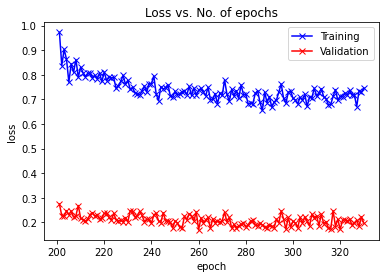

In [26]:
plot_losses(history['train_losses'][200:], history['valid_losses'][200:], history['epochs'][200:])

# plot_losses(history['train_losses'][10:], history['valid_losses'][10:], history['epochs'][10:])

Plot how the accuracy is changing for these 130 finetuning epochs

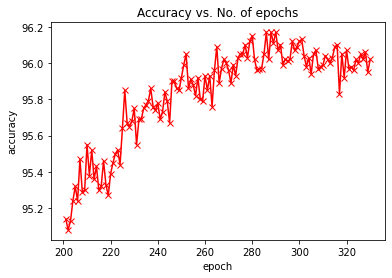

In [27]:
plot_accuracies(history['valid_accuracies'][200:], history['epochs'][200:])

# plot_accuracies(history['valid_accuracies'][10:], history['epochs'][10:])


Calculate and plot average accuracy like we did above

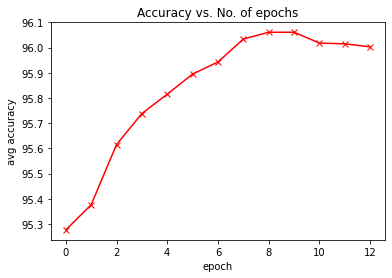

In [28]:
finetune_valid_accuracies = history['valid_accuracies'][200:]
# finetune_valid_accuracies = history['valid_accuracies'][10:]
avg_accuracies = [math.fsum(finetune_valid_accuracies[i*10:i*10+10])/10 for i in range(len(finetune_valid_accuracies)//10)]

plot_avg_accuracies(avg_accuracies)


#### Checkpoint 3
With this model on kaggle we were able to get **0.871** score on unlabelled data, a small improvement over previous score of 0.870. Maybe if we trained it for longer or if we had trained directly for 130 epochs it would have achieved better results but due to compute cost restrictions we were not able to test that out.
So, this is our final model.

#### Final Plots

Plot train and validation loss vs epochs for all 330 epochs of training,  there would be a sudden shift in training loss at epoch 200 since we added CutMix and MixUp augmentation at that point so it would have increased training loss

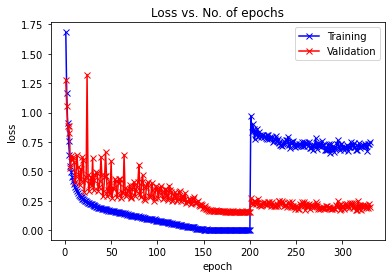

In [29]:
plot_losses(history['train_losses'], history['valid_losses'], history['epochs'])

Plot accuracy vs epochs for all 330 epochs of training

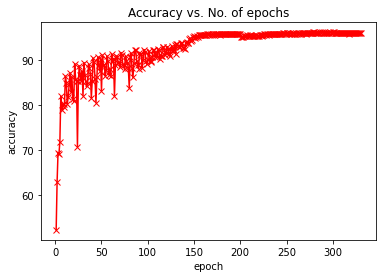

In [30]:
plot_accuracies(history['valid_accuracies'], history['epochs'])

Plot average accuracy for 10 epoch intervals for all training epochs

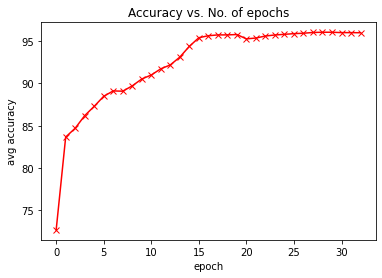

In [31]:
overall_valid_accuracies = history['valid_accuracies']
avg_accuracies = [math.fsum(overall_valid_accuracies[i*10:i*10+10])/10 for i in range(len(overall_valid_accuracies)//10)]

plot_avg_accuracies(avg_accuracies)

## Prediction on Unlabelled Data

### Data Loading

This part of the notebook was adapted from the starter [notebook](https://www.kaggle.com/competitions/deep-learning-mini-project-spring-24-nyu/discussion) given on kaggle.

For this keep the unlabeled data "*cifar_test_nolabels.pkl*" file in same directory as this notebook

In [32]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('cifar_test_nolabels.pkl')

# # Extract images
# images = cifar10_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) 

Let's see starting few images in unlabeled data

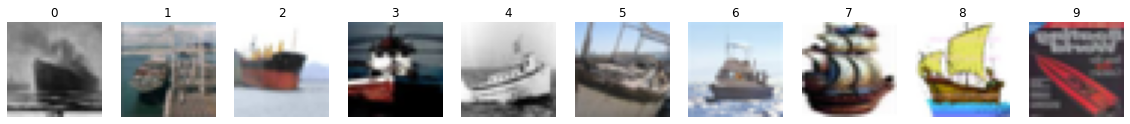

In [33]:
# Extract images and convert back to image format
images = cifar10_batch[b'data']
# Reshape to (number of images, width, height, channels)
images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.title(i)
    plt.axis('off')
plt.show()

Looks like first 10 images are all ships

Create Pytorch Dataset and Dataloader for unlabeled dataset

In [34]:
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]        
        if self.transform:
            image = Image.fromarray(x)
            x = self.transform(x)
        return x, index
    
    def __len__(self):
        return len(self.data)

unlabeled_dataset = MyDataset(images, transform=test)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=100)
print(len(unlabeled_dataset))
print(len(unlabeled_dataloader))

10000
100


Load the model with best accuracy for doing inference on unlabeled data, we can also check it's accuracy on validation data and also verify number of parameters once more

In [35]:
best_model= efficient_resnet_model()

best_model.load_state_dict(torch.load(PATH+'/best_model')) # to use latest model use (PATH+'/latest_model') instead
best_model.eval()
best_model = best_model.to(device)

test_acc = 0.0
for images,labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = best_model(images)
        prediction = torch.argmax(outputs, dim=1)
        k=torch.sum(prediction == labels)
        test_acc += k.item()
        val = 100*(k/len(images))

test_acc = 100*test_acc/len(test_dataset)
print(f'test accuracy: {test_acc}')

total_params = sum(p.numel() for p in best_model.parameters())
print(f"Number of parameters: {total_params}")

test accuracy: 96.17
Number of parameters: 4697742


Let's perform prediction on unlabeled dataset

In [36]:
# x, idx = unlabeled_dataset[0]
pred_list = []
idx_list = []
i =1
for x, idx in unlabeled_dataloader:
    x = x.to(device)
    outputs = best_model(x)
    _, predicted_classes = torch.max(outputs, 1)

    predicted_classes =predicted_classes.to('cpu')
    idx = idx.to('cpu')
    pred_list = pred_list + predicted_classes.tolist()
    idx_list = idx_list + idx.tolist()
    del x


In [37]:
# Let's check the predictions for first 10 images, they should all be ships
print(pred_list[0:10])

[8, 8, 8, 8, 8, 8, 8, 1, 8, 8]


CIFAR-10 has following label class combination:
0:airplane, 1:automobile, 2:bird, 3:cat, 4:deer, 5:dog, 6:frog, 7:horse, 8:ship, 9:truck
as per this above predictions look good, there is only one wrong prediction.

Now, we can save the predictions in a csv file for submission

In [38]:
import csv

# Open a new CSV file in write mode
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(['ID', 'Labels'])
    
    # Write the data rows
    for idx, pred in zip(idx_list, pred_list):
        writer.writerow([idx, pred])

In [39]:
# Clear GPU cache memory
torch.cuda.empty_cache()

## Final result
With these predictions we were able to get **0.871** score on unlabeled data on kaggle. Due to compute cost restrictions we were not able to train the model in just one iteration with 300 or 330 epochs with CutMix and MixUp enabled from the beginning as that would have smoothed out the loss curves and training, thus helping in achieving in better results.

To further improve model performance we can also try knowledge distillation by using a bigger network as teacher.